In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


# Load the first dataset
oasis_filtered_1 = pd.read_csv('./oasis_filtered_1.csv')

# Display the first few rows of the dataset
oasis_filtered_1.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,Group,Source,Diagnosis
0,OAS1_0001_MR1,0,R,-0.122643,-0.901332,0.508156,0.478191,-0.764869,Nondemented,OASIS-1,0
1,OAS1_0002_MR1,0,R,-2.050225,0.537958,-1.314609,0.478191,-0.764869,Nondemented,OASIS-1,0
2,OAS1_0003_MR1,0,R,-0.224095,0.537958,0.508156,-0.065249,0.560032,Demented,OASIS-1,1
3,OAS1_0010_MR1,1,R,-0.122643,1.257604,-0.403227,0.749911,-0.764869,Nondemented,OASIS-1,0
4,OAS1_0011_MR1,0,R,-2.354580,-0.181687,-0.403227,0.749911,-0.764869,Nondemented,OASIS-1,0


# Decision Trees #

Let's break down the process of creating a decision tree model for predictive modeling using the specified attributes from the oasis_filtered_1 dataset. We'll follow these steps:

1. Data Preparation: Select the relevant features and the target variable.
2. Data Splitting: We'll split the data into features (X) and the target variable (y). Then, split these into training and testing datasets.
3. Setting Up Decision Tree with GridSearchCV: We will set up a decision tree classifier with GridSearchCV to find the best hyperparameters. We'll include parameters like maximum depth of the tree (for pruning) and the minimum number of samples required to split a node.
4. 5-Fold Cross-Validation Setup: This will be integrated into the GridSearchCV process.
5. Training the Model: Using the training data to fit the model.
6. Evaluation: Calculating performance metrics, plotting ROC curves, confusion matrices, and visualizing the decision tree.

**Step 1: Data Preparation**
We will use the following features for our model: 'Age', 'M/F', 'Educ', 'SES', 'MMSE', 'CDR'. The target variable is 'Diagnosis'.

**Step 2: Data Splitting**
Let's split the data by 80% train set and 20% test set

**Step 3: Model Building with Cross-validation and GridSearchCV**
We will now set up a decision tree classifier using scikit-learn's DecisionTreeClassifier. To find the best model parameters and manage overfitting, we'll employ pruning through hyperparameter tuning using GridSearchCV. We'll also use 5-fold cross-validation during this process.

Pruning is important in decision trees to avoid overfitting, where the model performs well on training data but poorly on unseen data. Overfitting occurs when a model is too complex, capturing noise in the data rather than just the actual pattern. By tuning hyperparameters like max_depth (the maximum depth of the tree) and min_samples_split (the minimum number of samples required to split an internal node), min_samples_leaf (The minimum number of samples required to be at a leaf node) we can control the complexity of the model.

Let's set up the decision tree with GridSearchCV to find the best parameters using cross-validation. 

In [2]:
# Define features and target
X = oasis_filtered_1[['Age', 'M/F', 'Educ', 'SES', 'MMSE', 'CDR']]
y = oasis_filtered_1['Diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)

# Setting up parameters for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup the GridSearchCV
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'criterion': 'entropy',
  'max_depth': None,
  'min_samples_leaf': 4,
  'min_samples_split': 10},
 np.float64(0.9649905322953923))

The decision tree model was trained using 5-fold cross-validation with GridSearchCV to find the optimal parameters. The best parameters for the model are:

- Criterion: entropy
- Max Depth: None (no pruning was found to be the best in this scenario)
- Min Samples Leaf: 4 (the minimum number of samples required to be at a leaf node)
- Min Samples Split: 10 (the minimum number of samples required to split an internal node)

The best accuracy achieved with these parameters on the training data is approximately 96.5%.

# Feature Importance #

Decision tree models in scikit-learn automatically calculate feature importances based on how much each feature contributes to reducing the weighted impurity in a tree. This is a useful metric for understanding which attributes are the most influential in predicting the target variable.

Let's extract and visualize the feature importances from the decision tree model we trained. This will show us which features were most influential in the model's decisions.

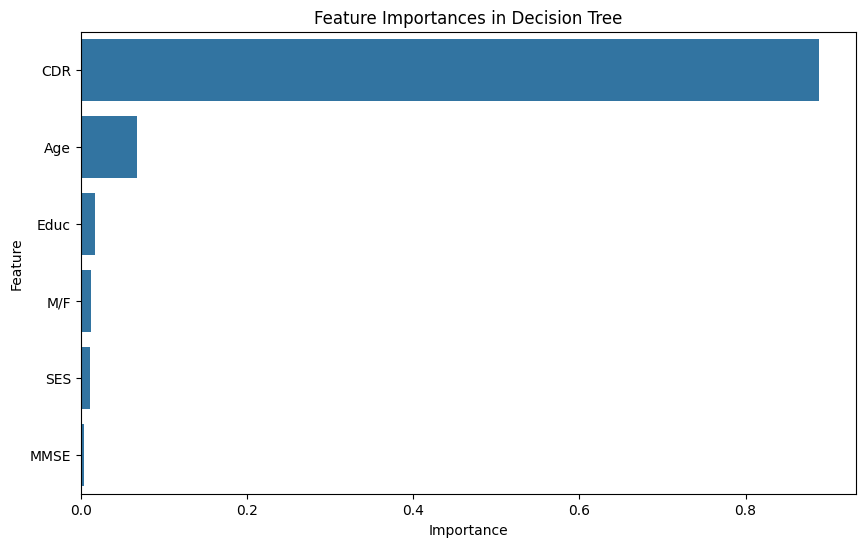

,Feature,Importance
5,CDR,0.888253
0,Age,0.067871
2,Educ,0.017224
1,M/F,0.012217
3,SES,0.010903
4,MMSE,0.003533


In [3]:
# Retrieve the best estimator
best_tree = grid_search.best_estimator_

# Get feature importances
feature_importances = best_tree.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print the DataFrame for reference
feature_importance_df

The bar chart above displays the relative importance of each feature used by the decision tree model. Here's what we can observe:

- **CDR (Clinical Dementia Rating)**: By far the most significant feature, accounting for about 88.8% of the importance. This suggests that CDR is a crucial indicator for predicting dementia in this dataset.

- **Age**: The next most important feature, though much less significant compared to CDR, contributing around 6.7% to the model's decisions.

- **M/F (Gender), Educ (Education), SES (Socioeconomic Status), and MMSE (Mini-Mental State Examination)**: These features have relatively minor importance in the model.

# Model Evaluation #

Next, we'll evaluate our model using these parameters on the test set. We will also look at other performance metrics like the confusion matrix, classification report and the ROC curve. Let's proceed with this evaluation. 

0.9426229508196722


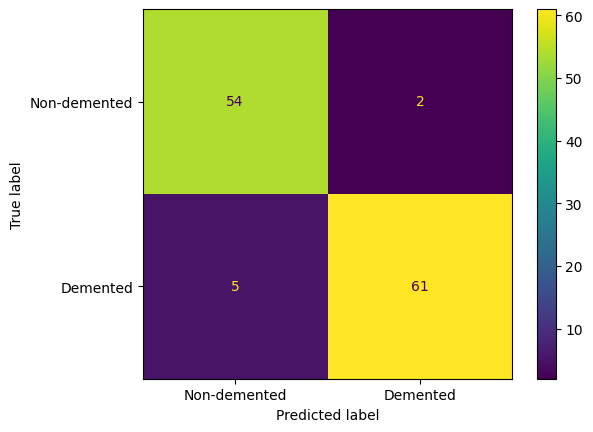

In [4]:
# Use the best parameters to create a new decision tree
best_tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_leaf=4, min_samples_split=10, random_state=42)
best_tree.fit(X_train, y_train)

# Predictions on the test set
y_pred = best_tree.predict(X_test)
y_pred_proba = best_tree.predict_proba(X_test)[:, 1]

# Evaluation metrics
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

class_report, conf_matrix

print(accuracy)

# Plotting the confusion matrix
conf_matrix=confusion_matrix(y_test, y_pred)
labels=['Non-demented', 'Demented']
ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot()

In [5]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        56
           1       0.97      0.92      0.95        66

    accuracy                           0.94       122
   macro avg       0.94      0.94      0.94       122
weighted avg       0.94      0.94      0.94       122



**Model Evaluation Summary**

Here are the performance metrics for our decision tree on the test set:

- **Accuracy**: Approximately 94%, indicating a high level of overall accuracy. 


- **Confusion Matrix**:

- True Negatives (correct non-demented predictions): 54 
- False Positives (non-demented incorrectly labeled as demented): 2 
- False Negatives (demented incorrectly labeled as non-demented): 5 
- True Positives (correct demented predictions): 61 


- **The Classification Report details**:

- **Precision** (correct positive predictions relative to total predicted positives): 
    - Non-demented: 92% 
    - Demented: 97% 
    
- **Recall** (correct positive predictions relative to total actual positives): 
    - Non-demented: 96% 
    - Demented: 92% 
    
- **F1-score**: A balanced measure of precision and recall, showing high values for both classes.

 # ROC Curve and its Visualization #

0.9734848484848485


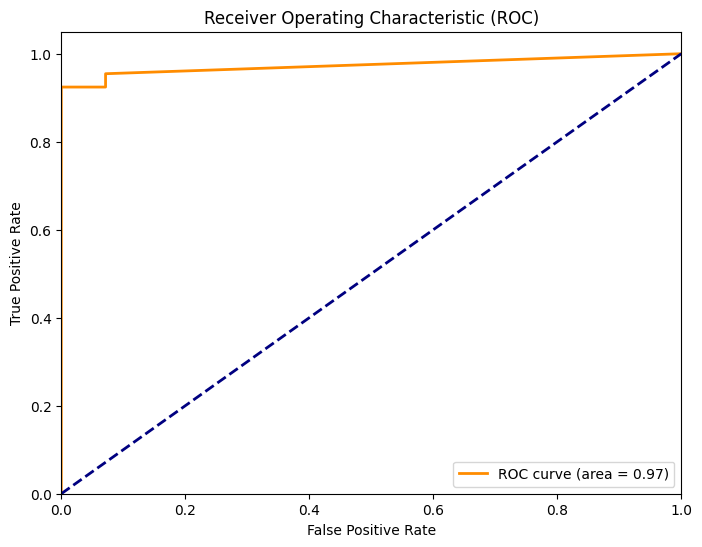

In [6]:
# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(roc_auc)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

The ROC curve above demonstrates the model's ability to differentiate between the two classes (demented and non-demented). The area under the curve (AUC) of approximately 0.97 indicates a high level of diagnostic ability.

# Decision Tree Visualization #

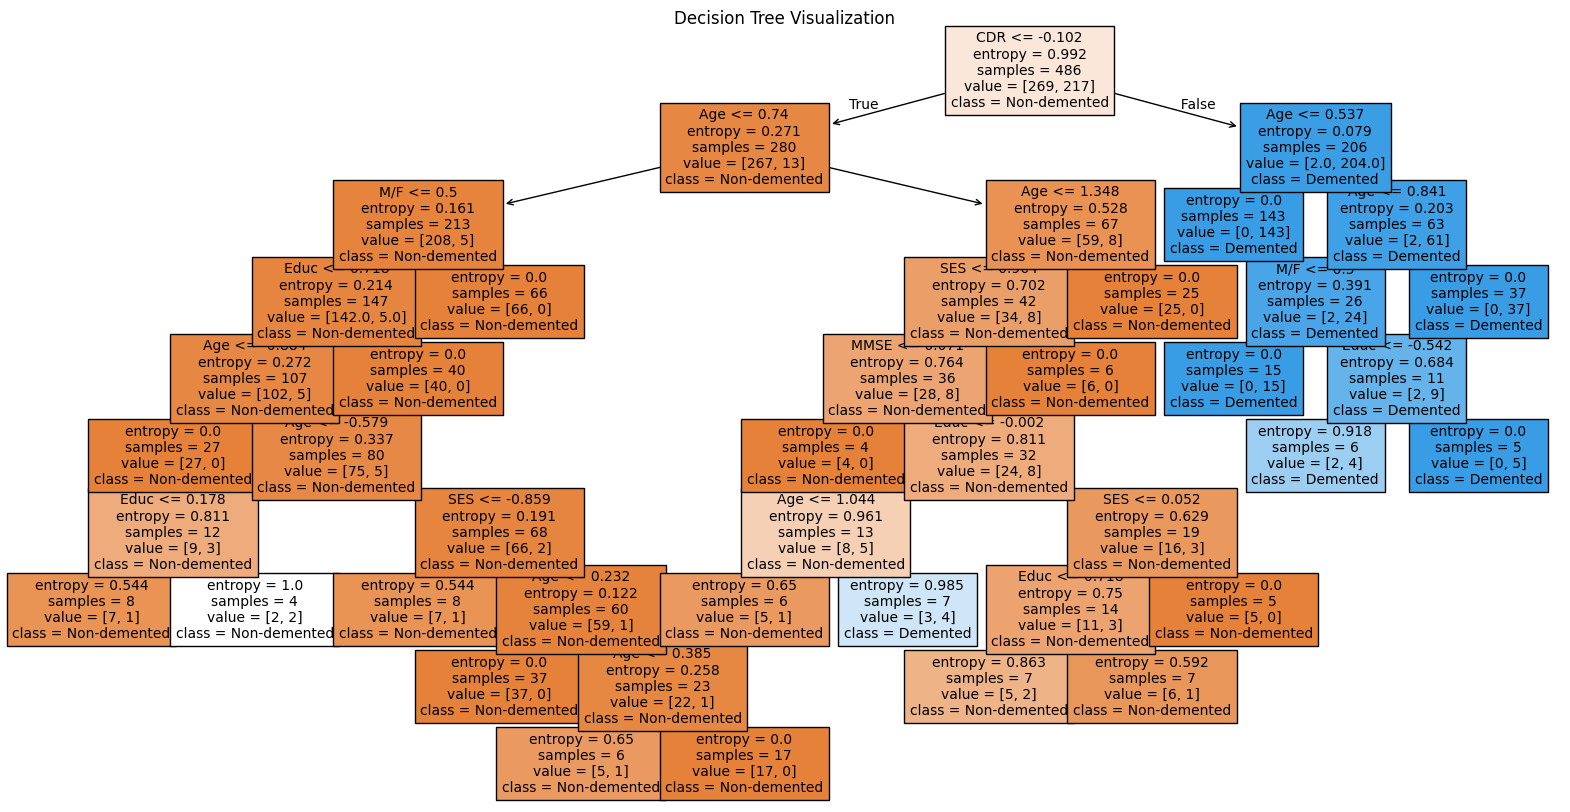

In [7]:
# Set up the figure size
plt.figure(figsize=(20,10))

# Plot the decision tree
plot_tree(best_tree, filled=True, feature_names=X.columns, class_names=['Non-demented', 'Demented'], fontsize=10)
plt.title('Decision Tree Visualization')
plt.show()

The tree plot above provides a graphical representation of the decision-making process of the model. Starting from the top, it begins with a decision based on gender (M/F <= 0.5), which likely translates to whether the individual is male or female, their age, or education level and, based on the answers, it leads you through different paths to a final decision: whether someone is likely "Demented" or "Non-demented". This root node has an entropy of 0.161 and represents 213 samplesThe colors on the tree typically help distinguish between these final categories: Orange boxes represent the classification "Demented" while the Blue boxes might represent "Non-demented." These colors help to quickly see which paths lead to which outcomes, making it visually easier to understand the pattern or trend.. Each decision point (box) uses data to split groups into smaller ones, more accurately predicting the outcome as it branches out.

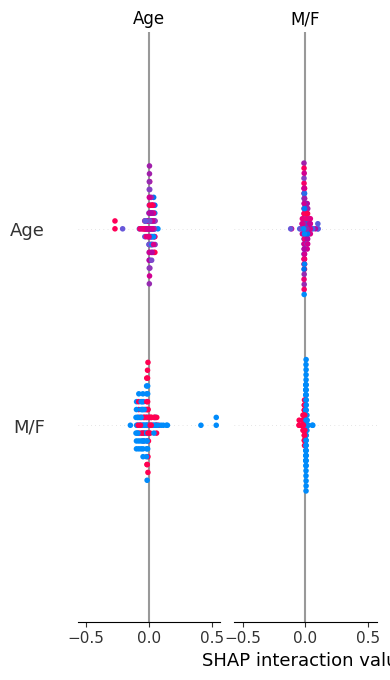

In [8]:
import shap

# Calculate SHAP Values to interpret the model
explainer = shap.TreeExplainer(best_tree)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [9]:
import time

# Start the timer for the training process
start_time = time.time()

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# End the training timer and start the prediction timer
train_time = time.time() - start_time
start_time = time.time()

# Predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# End the prediction timer
predict_time = time.time() - start_time

# Total samples processed (training + testing)
total_samples = len(X_train) + len(X_test)

# Calculate the time per sample
time_per_sample = (train_time + predict_time) / total_samples

print(f"Total training time: {train_time:.4f}s")
print(f"Total prediction time: {predict_time:.4f}s")
print(f"Processing time per sample: {time_per_sample:.4f}s/sample")

Total training time: 8.3705s
Total prediction time: 0.0091s
Processing time per sample: 0.0138s/sample
